# Introduction

This program draws a "heat map" of COVID cases based on the Covid-19 dataset. The dataset includes information about
case counts over time. <br>
It relies on a pre-made country map JSON to make the Folium overlay, and a "better_names" csv which I wrote so that the
code wouldn't get too cluttered.

# Main Program

## Init

Imports standard libraries:

In [53]:
import numpy as np
import pandas as pd
import matplotlib as mp
import folium as fol
import pycountry as pc
from urllib.request import urlopen
from json import load

Loads data files on GitHub (for Colab)

In [54]:
COVID_DATA_URL = "https://raw.githubusercontent.com/WBArno/PDA_Project/master/Dat/covid_19_data.csv"
BETTER_NAMES_URL = "https://raw.githubusercontent.com/WBArno/PDA_Project/master/Dat/better_names.csv"
MERGED_COUNTRIES_URL = "https://raw.githubusercontent.com/WBArno/PDA_Project/master/Dat/merged_countries.json"

# df = pd.read_csv(COVID_DATA_URL)
# bn = pd.read_csv(BETTER_NAMES_URL)
# ct = load(urlopen(MERGED_COUNTRIES_URL))

Loads Data Files (for execution locally/ GitHub).

In [55]:
df = pd.read_csv("../Dat/covid_19_data.csv")
bn = pd.read_csv("../Dat/better_names.csv")
ct = load(open("../Dat/merged_countries.json"))


## -- Run --

Function which changes the poorly-named-countries into ones that PyCountry can recognize.

In [56]:
def sanitize_csv(original, new):
    if new == "nil" or new is None:
        df["Country"] = df["Country"].str.replace(original, "", regex=True)
    else:
        df["Country"] = df["Country"].str.replace(original, new, regex=True)

Prepares the table for use by dropping unneeded columns and renaming an annoying one.


In [57]:
df.drop(["SNo", "ObservationDate", "Recovered", "Last Update", "Deaths"], axis=1, inplace=True)
df.rename(columns = {"Country/Region": "Country"}, inplace=True)

"Sanitizes" the country names so that PyCountry will recognize them, then collapses them all together.

In [58]:
for row in bn.itertuples(): sanitize_csv(row[1], row[2])

Groups by and finds the maximum value for each state (the entries are cumulative, so a single group would result in an
absurd amount of cases.)

In [59]:
df = df.groupby(["Country", "Province/State"], as_index=False, dropna=False).aggregate({"Confirmed":"last"})

Groups the table again by country, finding the sum of all of the states.

In [60]:
df = df.groupby(["Country"], as_index=False, dropna=False).aggregate({"Confirmed":"sum"})

Uses PyCountry to find the three-letter acronym for each country for use with Folium.

In [61]:
for row in df["Country"]: df["Country"] = df["Country"].replace(row, pc.countries.search_fuzzy(row)[0].alpha_3)

Takes the log of all values in order to make a more meaningful map. <br>
Without this step, only three countries would be colored anything other than yellow.

In [62]:
for row in df["Confirmed"]: df["Confirmed"] = df["Confirmed"].replace(row, np.log(row))
df.dropna(inplace=True) # Necessary to remove broken entries created by the above process.

<ipython-input-62-43e808d261fd>:1: RuntimeWarning: divide by zero encountered in log
  for row in df["Confirmed"]: df["Confirmed"] = df["Confirmed"].replace(row, np.log(row))
<ipython-input-62-43e808d261fd>:1: RuntimeWarning: invalid value encountered in log
  for row in df["Confirmed"]: df["Confirmed"] = df["Confirmed"].replace(row, np.log(row))


Creates the Folium map.

In [63]:
outbreak_map = fol.Map(location=[0, 0], zoom_start=0)

fol.Choropleth(
    name = "COVID Cases",
    geo_data = ct, # Polygonal data to draw the country map.
    data = df, # COVID case data
    columns = ["Country", "Confirmed"], # Column to match with the key, count-based column.
    key_on = "feature.id", # Establishes the key of the country JSON.
    fill_color = "YlOrRd", # Color scheme
    fill_opacity = 0.75,
    line_opacity = 0.25,
    nan_fill_opacity = 0,
    legend_name = "Confirmed Cases",
    highlight = True,
).add_to(outbreak_map)

Creates an overlay for the above folium map which displays the confirmed count.

In [64]:
OverlayData = fol.features.GeoJson(
    ct,
    style_function = lambda x: {'fillColor': '#ffffff', 'color':'#000000', 'fillOpacity': 0.2, 'weight': 0.2},
    highlight_function = lambda x: {'fillColor': '#000000', 'color':'#000000', 'fillOpacity': 0.50, 'weight': 0.1},
    control = False,
    tooltip = fol.features.GeoJsonTooltip(
        fields = ["name", "Confirmed"],
        aliases = ["Country: ", "Confirmed Cases: "],
        style = "background-color: white; color: #333333; font-family: arial; font-size: 12px; padding: 10px;"
    )
)

outbreak_map.add_child(OverlayData)
outbreak_map.keep_in_front(OverlayData)
fol.LayerControl().add_to(outbreak_map)

## Map of the COVID Outbreak

In [65]:
outbreak_map

# Project Tasks

## Stage 1 - Using Pandas

### 1.3 - Loading a Dataframe

Loads the dataframe again; the import call is commented out, as it was done earlier.

In [66]:
# import pandas as pd
CSV_DATA = "https://raw.githubusercontent.com/WBArno/PDA_Project/master/Dat/covid_19_data.csv"

# df = pd.read_csv(CSV_DATA)                # Loads data from GitHub (CoLab)
df = pd.read_csv("../Dat/covid_19_data.csv")# Loads local data (Local/Git)

Sanitizes the master dataframe (again) to clean up country names.

In [67]:
df.rename(columns = {"Country/Region": "Country"}, inplace=True)
for row in bn.itertuples(): sanitize_csv(row[1], row[2])
df.rename(columns = {"Country": "Country/Region"}, inplace=True) # Resets title scheme back to original.

### 1.4 - Manipulation with Workflows

#### 1.4a - Datatypes

Displays the datatypes in the dataset.

In [68]:
print("Data Types:\n", df.dtypes)

Data Types:
 SNo                  int64
ObservationDate     object
Province/State      object
Country/Region      object
Last Update         object
Confirmed          float64
Deaths             float64
Recovered          float64
dtype: object


#### 1.4b - Top

Displays the top of the dataframe with .head()

In [69]:
print("Top of Set:\n", df.head())

Top of Set:
    SNo ObservationDate Province/State Country/Region      Last Update  \
0    1      01/22/2020          Anhui          China  1/22/2020 17:00   
1    2      01/22/2020        Beijing          China  1/22/2020 17:00   
2    3      01/22/2020      Chongqing          China  1/22/2020 17:00   
3    4      01/22/2020         Fujian          China  1/22/2020 17:00   
4    5      01/22/2020          Gansu          China  1/22/2020 17:00   

   Confirmed  Deaths  Recovered  
0        1.0     0.0        0.0  
1       14.0     0.0        0.0  
2        6.0     0.0        0.0  
3        1.0     0.0        0.0  
4        0.0     0.0        0.0  


#### 1.4c - Summary

Creates an automatically-generated statistical summary of the dataframe.

In [70]:
print("Summary:\n", df.describe())

Summary:
                  SNo     Confirmed         Deaths     Recovered
count  236017.000000  2.360170e+05  236017.000000  2.360170e+05
mean   118009.000000  5.715800e+04    1487.719368  3.393027e+04
std     68132.383579  1.834751e+05    4770.414639  1.474800e+05
min         1.000000 -3.028440e+05    -178.000000 -8.544050e+05
25%     59005.000000  7.270000e+02       9.000000  1.000000e+01
50%    118009.000000  6.695000e+03     127.000000  1.224000e+03
75%    177013.000000  3.349900e+04     880.000000  1.263900e+04
max    236017.000000  3.664050e+06  108208.000000  6.399531e+06


## Stage 2 - Manipulating and Writing Data

### 2.4 - Adding/Editing Columns

Creates a new dataframe for this section.

In [71]:
p2 = df.copy()

Combines "Province/State" and "Country/Region" into a new column ("Location") in the form "Province, Country".

In [72]:
p2["Location"] = p2["Province/State"] + ", " + p2["Country/Region"]
p2

,SNo,ObservationDate,Province/State,Country/Region,Last Update,Confirmed,Deaths,Recovered,Location
0,1,01/22/2020,Anhui,China,1/22/2020 17:00,1.0,0.0,0.0,"Anhui, China"
1,2,01/22/2020,Beijing,China,1/22/2020 17:00,14.0,0.0,0.0,"Beijing, China"
2,3,01/22/2020,Chongqing,China,1/22/2020 17:00,6.0,0.0,0.0,"Chongqing, China"
3,4,01/22/2020,Fujian,China,1/22/2020 17:00,1.0,0.0,0.0,"Fujian, China"
4,5,01/22/2020,Gansu,China,1/22/2020 17:00,0.0,0.0,0.0,"Gansu, China"
...,...,...,...,...,...,...,...,...,...
236012,236013,02/27/2021,Zaporizhia Oblast,Ukraine,2021-02-28 05:22:20,69504.0,1132.0,65049.0,"Zaporizhia Oblast, Ukraine"
236013,236014,02/27/2021,Zeeland,Netherlands,2021-02-28 05:22:20,16480.0,178.0,0.0,"Zeeland, Netherlands"
236014,236015,02/27/2021,Zhejiang,China,2021-02-28 05:22:20,1321.0,1.0,1314.0,"Zhejiang, China"
236015,236016,02/27/2021,Zhytomyr Oblast,Ukraine,2021-02-28 05:22:20,50582.0,834.0,44309.0,"Zhytomyr Oblast, Ukraine"


### 2.7a - Creating a Subset

Uses .groupby().agg() to narrow down the table into a more useful form. <br>
Dataset is filtered before other steps to speed up the process.

In [73]:
# as_index = False so that the next stage is possible.
p2 = p2.groupby(["SNo", "ObservationDate", "Location", "Confirmed", "Recovered", "Deaths"],
                as_index=False).agg({"Recovered":"sum"})
p2

,SNo,ObservationDate,Location,Confirmed,Deaths,Recovered
0,1,01/22/2020,"Anhui, China",1.0,0.0,0.0
1,2,01/22/2020,"Beijing, China",14.0,0.0,0.0
2,3,01/22/2020,"Chongqing, China",6.0,0.0,0.0
3,4,01/22/2020,"Fujian, China",1.0,0.0,0.0
4,5,01/22/2020,"Gansu, China",0.0,0.0,0.0
...,...,...,...,...,...,...
173967,236013,02/27/2021,"Zaporizhia Oblast, Ukraine",69504.0,1132.0,65049.0
173968,236014,02/27/2021,"Zeeland, Netherlands",16480.0,178.0,0.0
173969,236015,02/27/2021,"Zhejiang, China",1321.0,1.0,1314.0
173970,236016,02/27/2021,"Zhytomyr Oblast, Ukraine",50582.0,834.0,44309.0


### 2.6 - set_index()

Sets the index to "SNo", which is the original index number for the dataset.

In [74]:
p2.set_index(["SNo"], inplace=True)
p2

,ObservationDate,Location,Confirmed,Deaths,Recovered
SNo,,,,,
1,01/22/2020,"Anhui, China",1.0,0.0,0.0
2,01/22/2020,"Beijing, China",14.0,0.0,0.0
3,01/22/2020,"Chongqing, China",6.0,0.0,0.0
4,01/22/2020,"Fujian, China",1.0,0.0,0.0
5,01/22/2020,"Gansu, China",0.0,0.0,0.0
...,...,...,...,...,...
236013,02/27/2021,"Zaporizhia Oblast, Ukraine",69504.0,1132.0,65049.0
236014,02/27/2021,"Zeeland, Netherlands",16480.0,178.0,0.0
236015,02/27/2021,"Zhejiang, China",1321.0,1.0,1314.0


### 2.5 - A Filtering Operation

Filters the dataset so that only entries with a "Recovered" value greater than the mean will be included. <br>
This reduces the dataset by a factor of ten.

In [75]:
p2 = p2[p2.Recovered > p2.Recovered.mean()]
p2

,ObservationDate,Location,Confirmed,Deaths,Recovered
SNo,,,,,
2819,03/01/2020,"Hubei, China",66907.0,2761.0,31536.0
2944,03/02/2020,"Hubei, China",67103.0,2803.0,33934.0
3085,03/03/2020,"Hubei, China",67217.0,2835.0,36208.0
3236,03/04/2020,"Hubei, China",67332.0,2871.0,38557.0
3396,03/05/2020,"Hubei, China",67466.0,2902.0,40592.0
...,...,...,...,...,...
236006,02/27/2021,"Yaroslavl Oblast, Russia",32668.0,397.0,31016.0
236010,02/27/2021,"Zabaykalsky Krai, Russia",38523.0,528.0,36849.0
236012,02/27/2021,"Zakarpattia Oblast, Ukraine",39830.0,900.0,30516.0


### 2.7b - to_csv()

Saves the filtered dataframe to "test_output.csv" in the working folder.

In [76]:
p2.to_csv("test_output.csv")

## Stage 3 - Data Cleansing and Plotting

### Part 3.1 - NaN

#### 3.1.1 - isna()

Finds the number of missing values in the table by column.

In [77]:
p3 = df.copy()
p3.isna().sum()

SNo                    0
ObservationDate        0
Province/State     62045
Country/Region         0
Last Update            0
Confirmed              0
Deaths                 0
Recovered              0
dtype: int64

There are 62,045 missing values in the table; all located under the Province/State column.

#### 3.1.3 - dropna()

Drops all of the rows with null values. <br>
Displays a count of all remaining NaN values to show

In [78]:
trunc = p3.dropna()
trunc.isna().sum().sum() # Total count of NaN values

0

#### 3.1.2 - fillna()

Instead of dropping the null values, this replaces them with "Undefined". <br>
Prints a row with a null value before/after the modification to show the change.

In [79]:
print(p3["Province/State"][35])
p3.fillna("Undefined", inplace=True)
print(p3["Province/State"][35])
p3.isna().sum().sum() # Total count of NaN values.

nan
Undefined


0

### Part 3.2 - Plotting

#### 3.2.1 - Histograms

Creates a set of histograms by sorted data:<br>
1) Confirmed Cases:

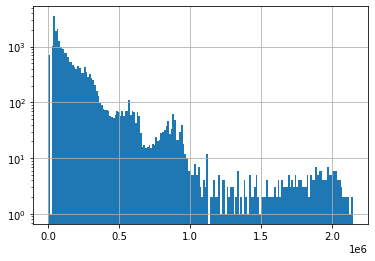

In [80]:
# Using the filtered plot from Stage 2 to reduce migraines (caused by the number of data points) slightly.
p2_state_hist = p2["Confirmed"].hist(bins="auto", log=True)

2) Recovered Cases:

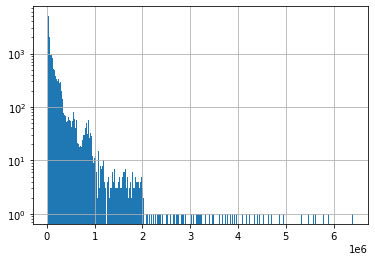

In [81]:
p2_chaos_hist = p2["Recovered"].hist(bins="auto", log=True)

3) Deaths:

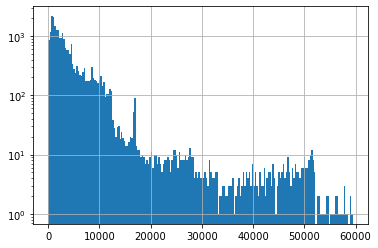

In [82]:
p2_balanced_hist = p2["Deaths"].hist(bins="auto", log=True)

#### 3.2.2 - Plots Within Plots

All three plots, but together now!

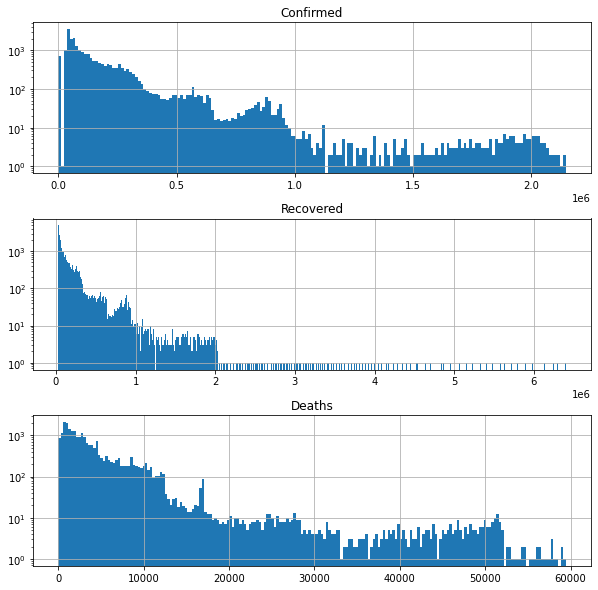

In [83]:
p2_grouped_hist = p2.hist(column=["Confirmed", "Recovered", "Deaths"],
                          bins="auto", layout=(3, 1), figsize=(10, 10), log=True)

#### 3.2.3 - Single-Line Graph

This is an attempt at graphing recovered cases over time. <br>
*It turns out that 20,000 data points don't make for a good line graph.*

<ipython-input-84-68ada921e99f>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  p2["ObservationDate"] = pd.to_datetime(p2["ObservationDate"])
<ipython-input-84-68ada921e99f>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  p2.sort_values(by="ObservationDate", ascending=True, inplace=True)


<AxesSubplot:xlabel='ObservationDate'>

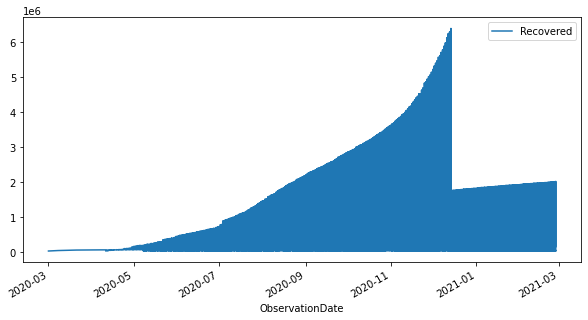

In [84]:
p2["ObservationDate"] = pd.to_datetime(p2["ObservationDate"])
p2.sort_values(by="ObservationDate", ascending=True, inplace=True)
p2.plot(x="ObservationDate", y="Recovered", figsize=(10,5))

#### 3.2.4 - Multi-Line Graph

Now with less data points! <br>
Creates a function to reduce redundant code in this section somewhat.


In [85]:
def aggravate(tmp_series, target):
    return tmp_series.aggregate({target:"last"}).groupby(["Country/Region"], as_index=False,
                                                         dropna=False).aggregate({target:"sum"})[target]

Creates a temporary *unsorted* dataframe for use with the "aggravate" function.

In [86]:
tmp_ser = df.groupby(["Country/Region", "Province/State"], as_index=False, dropna=False)

Creates a new dataframe (lg) which is filtered to both make the data more meaningful and reduce the number of datapoints.


In [87]:
lg = pd.DataFrame()
lg["Country"] = (tmp_ser.aggregate({"Confirmed":"last"}).groupby(["Country/Region"], as_index=False,dropna=False).
                 aggregate({"Confirmed":"sum"}))["Country/Region"]
lg["Confirmed"] = aggravate(tmp_ser, "Confirmed")
lg["Recovered"] = aggravate(tmp_ser, "Recovered")
lg["Deaths"] = aggravate(tmp_ser, "Deaths")

Creates a line graph out of the newly-filtered function using the number of confirmed cases as the x-axis.

Text(0.5, 100, '|----------?----------|')

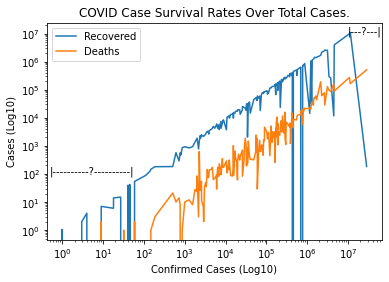

In [88]:
lg.sort_values(by="Confirmed", ascending=True, inplace=True)
lg.plot(
    'Confirmed', # X-Axis index
    title="COVID Case Survival Rates Over Total Cases.",
    ylabel="Cases (Log10)",
    xlabel="Confirmed Cases (Log10)",
    legend=True,
    loglog=True # Sets both axes to a logarithmic scale.
)

mp.pyplot.annotate('|---?---|', (10**7, 10**7))
mp.pyplot.annotate('|----------?----------|', (0.5, 100))

#### 3.2.5 - Bar Graph

Now with beautiful labels! <br>
Saves the artwork to a .png in the working folder.

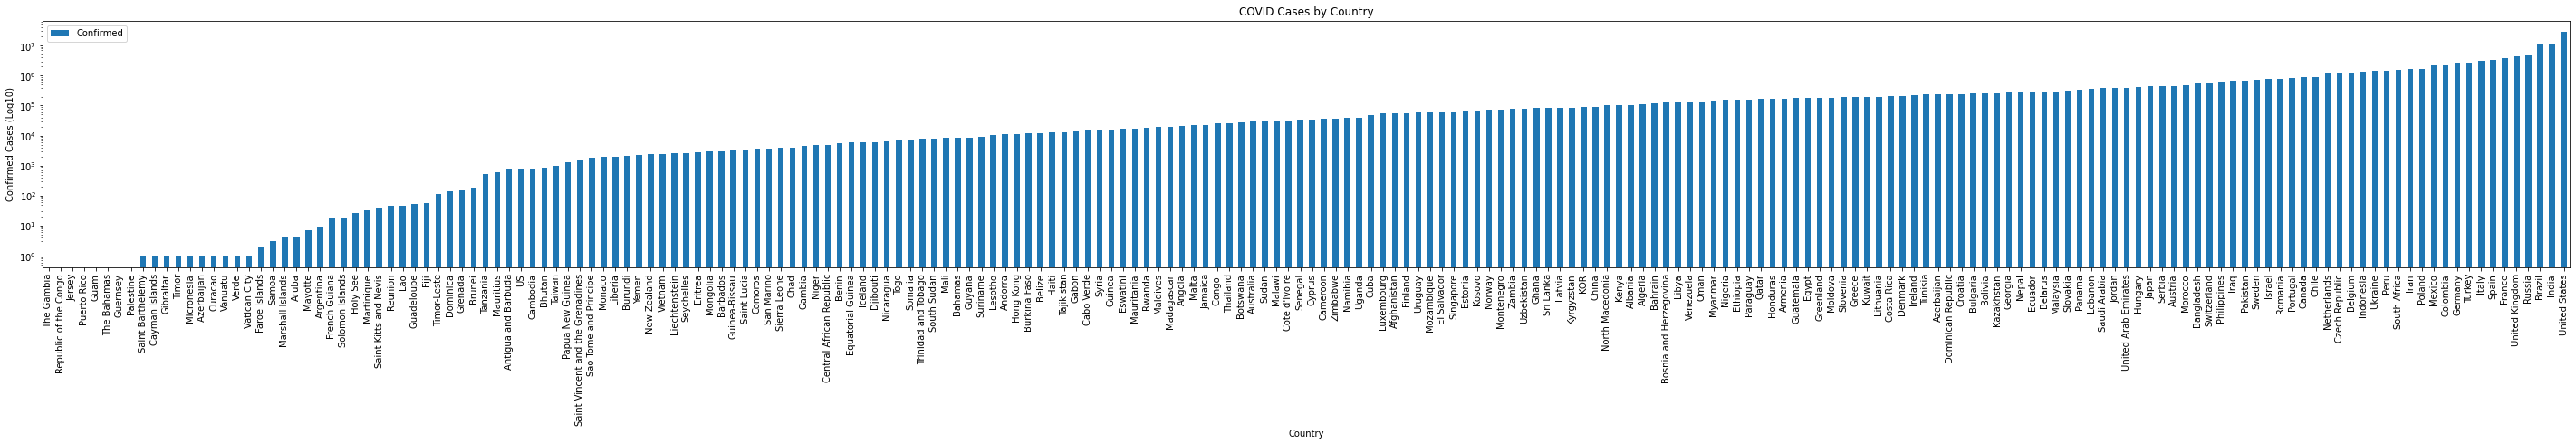

In [89]:
lg_bar = lg
lg_bar.set_index("Country")
lg_bar.plot.bar(
    "Country", "Confirmed", # X-Axis, Y-Axis
    title="COVID Cases by Country",
    ylabel="Confirmed Cases (Log10)",
    figsize=(50,5),
    legend=True,
    logy=True
)

mp.pyplot.savefig("not_modern_art.png")

## Stage 4 - Data Wrangling

### Part 4.1 - Hierarchical Indexing

#### Part 4.1.1 - .set_index()

- Duplicates the master dataframe into p4.
- Drops unwanted columns.
- Drops the duplicates in "Province/State", keeping the last (most recent) entry.

In [90]:
p4 = df.copy()
p4.drop(["SNo", "ObservationDate", "Last Update"], axis=1, inplace=True) # Removes the redundant index.

p4.drop_duplicates(["Country/Region", "Province/State"], keep="last", inplace=True)

- Creates a hierarchical index from the country and state.<br>
- Sorts the index.

In [91]:
p4_hier = p4.set_index(["Country/Region", "Province/State"])
p4_hier.sort_index(inplace=True)
p4_hier.index

MultiIndex([(        ' Azerbaijan', nan),
            (        'Afghanistan', nan),
            (            'Albania', nan),
            (            'Algeria', nan),
            (            'Andorra', nan),
            (             'Angola', nan),
            ('Antigua and Barbuda', nan),
            (          'Argentina', nan),
            (            'Armenia', nan),
            (              'Aruba', nan),
            ...
            (            'Uruguay', nan),
            (         'Uzbekistan', nan),
            (            'Vanuatu', nan),
            (       'Vatican City', nan),
            (          'Venezuela', nan),
            (              'Verde', nan),
            (            'Vietnam', nan),
            (              'Yemen', nan),
            (             'Zambia', nan),
            (           'Zimbabwe', nan)],
           names=['Country/Region', 'Province/State'], length=970)

#### Part 4.1.2 - .unstack()

Unstacks the dataframe at "Province/State" and makes a mess: <br>
I'm not sure why, but only 28 countries are listed. <br>
This intentionally makes no changes to the dataframe so that it can be used in the next section.

In [92]:
p4_hier.unstack(level="Country/Region", fill_value=" ")

Confirmed                                           \
Country/Region       Azerbaijan Afghanistan   Albania   Algeria  Andorra   
Province/State                                                             
NaN                         1.0     55707.0  106215.0  112960.0  10849.0   
 Montreal, QC                                                              
 Norfolk County, MA                                                        
Abruzzo                                                                    
Acre                                                                       
...                         ...         ...       ...       ...      ...   
Zaporizhia Oblast                                                          
Zeeland                                                                    
Zhejiang                                                                   
Zhytomyr Oblast                                                            
Zuid-Holland                                                               

                                                                            \
Country/Region        Angola Antigua and Barbuda Argentina   Armenia Aruba   
Province/State                                                               
NaN                  20782.0               726.0       9.0  171793.0   4.0   
 Montreal, QC                                                                
 Norfolk County, MA                                                          
Abruzzo                                                                      
Acre                                                                         
...                      ...                 ...       ...       ...   ...   
Zaporizhia Oblast                                                            
Zeeland                                                                      
Zhejiang                                                                     
Zhytomyr Oblast                                                              
Zuid-Holland                                                                 

                     ... Recovered                                            \
Country/Region       ...   Uruguay Uzbekistan Vanuatu Vatican City Venezuela   
Province/State       ...                                                       
NaN                  ...   49466.0    78373.0     1.0          0.0  130834.0   
 Montreal, QC        ...                                                       
 Norfolk County, MA  ...                                                       
Abruzzo              ...                                                       
Acre                 ...                                                       
...                  ...       ...        ...     ...          ...       ...   
Zaporizhia Oblast    ...                                                       
Zeeland              ...                                                       
Zhejiang             ...                                                       
Zhytomyr Oblast      ...                                                       
Zuid-Holland         ...                                                       

                                                             
Country/Region      Verde Vietnam   Yemen   Zambia Zimbabwe  
Province/State                                               
NaN                   0.0  1844.0  1435.0  73609.0  32590.0  
 Montreal, QC                                                
 Norfolk County, MA                                          
Abruzzo                                                      
Acre                                                         
...                   ...     ...     ...      ...      ...  
Zaporizhia Oblast                                            
Zeeland                                                      
Zhejiang                                                     

Earlier, .unstack() resulted in: <br>
"MemoryError: Unable to allocate 3.88 GiB for an array with shape (235243, 2214) and data type object"<br>
I assume GitHub/CoLab would not appreciate that.

#### Part 4.1.3 - Summary Statistics

Uses the hierarchical index and .sum() to find the total number of confirmed cases/ deaths/ recoveries.

In [93]:
p4_hier.sum(level="Country/Region")

,Confirmed,Deaths,Recovered
Country/Region,,,
Azerbaijan,1.0,0.0,0.0
Afghanistan,55707.0,2443.0,49288.0
Albania,106215.0,1775.0,68969.0
Algeria,112960.0,2979.0,77976.0
Andorra,10849.0,110.0,10429.0
...,...,...,...
Verde,1.0,0.0,0.0
Vietnam,2432.0,35.0,1844.0
Yemen,2269.0,631.0,1435.0


#### Part 4.1.4 - .pivot()

- Creates a pivot group by Country/Region and Province/State.
- .fillna() managed to crash pycharm then freeze my computer.

In [94]:
p4_pivot = p4.pivot("Country/Region", "Province/State")

# p4_pivot.fillna(" ", inplace=True)
p4_pivot

Confirmed                                                 \
Province/State       NaN  Montreal, QC  Norfolk County, MA Abruzzo Acre   
Country/Region                                                            
 Azerbaijan          1.0           NaN                 NaN     NaN  NaN   
Afghanistan      55707.0           NaN                 NaN     NaN  NaN   
Albania         106215.0           NaN                 NaN     NaN  NaN   
Algeria         112960.0           NaN                 NaN     NaN  NaN   
Andorra          10849.0           NaN                 NaN     NaN  NaN   
...                  ...           ...                 ...     ...  ...   
Verde                1.0           NaN                 NaN     NaN  NaN   
Vietnam           2432.0           NaN                 NaN     NaN  NaN   
Yemen             2269.0           NaN                 NaN     NaN  NaN   
Zambia           78202.0           NaN                 NaN     NaN  NaN   
Zimbabwe         36058.0           NaN                 NaN     NaN  NaN   

                                                                   ...  \
Province/State Adygea Republic Aguascalientes Aichi Akita Alabama  ...   
Country/Region                                                     ...   
 Azerbaijan                NaN            NaN   NaN   NaN     NaN  ...   
Afghanistan                NaN            NaN   NaN   NaN     NaN  ...   
Albania                    NaN            NaN   NaN   NaN     NaN  ...   
Algeria                    NaN            NaN   NaN   NaN     NaN  ...   
Andorra                    NaN            NaN   NaN   NaN     NaN  ...   
...                        ...            ...   ...   ...     ...  ...   
Verde                      NaN            NaN   NaN   NaN     NaN  ...   
Vietnam                    NaN            NaN   NaN   NaN     NaN  ...   
Yemen                      NaN            NaN   NaN   NaN     NaN  ...   
Zambia                     NaN            NaN   NaN   NaN     NaN  ...   
Zimbabwe                   NaN            NaN   NaN   NaN     NaN  ...   

               Recovered                                                       \
Province/State     Yukon Yunnan Zabaykalsky Krai Zacatecas Zakarpattia Oblast   
Country/Region                                                                  
 Azerbaijan          NaN    NaN              NaN       NaN                NaN   
Afghanistan          NaN    NaN              NaN       NaN                NaN   
Albania              NaN    NaN              NaN       NaN                NaN   
Algeria              NaN    NaN              NaN       NaN                NaN   
Andorra              NaN    NaN              NaN       NaN                NaN   
...                  ...    ...              ...       ...                ...   
Verde                NaN    NaN              NaN       NaN                NaN   
Vietnam              NaN    NaN              NaN       NaN                NaN   
Yemen                NaN    NaN              NaN       NaN                NaN   
Zambia               NaN    NaN              NaN       NaN                NaN   
Zimbabwe             NaN    NaN              NaN       NaN                NaN   

                                                                                
Province/State Zaporizhia Oblast Zeeland Zhejiang Zhytomyr Oblast Zuid-Holland  
Country/Region                                                                  
 Azerbaijan                  NaN     NaN      NaN             NaN          NaN  
Afghanistan                  NaN     NaN      NaN             NaN          NaN  
Albania                      NaN     NaN      NaN             NaN          NaN  
Algeria                      NaN     NaN      NaN             NaN          NaN  
Andorra                      NaN     NaN      NaN             NaN          NaN  
...                          ...     ...      ...             ...          ...  
Verde                        NaN     NaN      NaN             N

This results in an identical copy of the unstacked table, as pivots are just a more concise way of using
.set_index().unstack()
The value arg of .pivot() does not need to be set, as the unwanted columns were dropped from p4.
This method is much more concise, but allows for less options than unstack.

#### Part 4.1.5 - .groupby() -> Unstack

.groupby was used several times throughout the project to make the data more useful.

In [95]:
p4_group = df.groupby(["Country/Region", "Province/State"], dropna=False).aggregate({"Confirmed":"last"})
p4_group = p4_group.unstack("Province/State", fill_value=" ")

p4_group

Confirmed                                                   \
Province/State  Montreal, QC  Norfolk County, MA Abruzzo Acre Adygea Republic   
Country/Region                                                                  
 Azerbaijan                                                                     
Afghanistan                                                                     
Albania                                                                         
Algeria                                                                         
Andorra                                                                         
...                      ...                 ...     ...  ...             ...   
Verde                                                                           
Vietnam                                                                         
Yemen                                                                           
Zambia                                                                          
Zimbabwe                                                                        

                                                           ...         \
Province/State Aguascalientes Aichi Akita Alabama Alagoas  ... Yunnan   
Country/Region                                             ...          
 Azerbaijan                                                ...          
Afghanistan                                                ...          
Albania                                                    ...          
Algeria                                                    ...          
Andorra                                                    ...          
...                       ...   ...   ...     ...     ...  ...    ...   
Verde                                                      ...          
Vietnam                                                    ...          
Yemen                                                      ...          
Zambia                                                     ...          
Zimbabwe                                                   ...          

                                                              \
Province/State Zabaykalsky Krai Zacatecas Zakarpattia Oblast   
Country/Region                                                 
 Azerbaijan                                                    
Afghanistan                                                    
Albania                                                        
Algeria                                                        
Andorra                                                        
...                         ...       ...                ...   
Verde                                                          
Vietnam                                                        
Yemen                                                          
Zambia                                                         
Zimbabwe                                                       

                                                                   \
Province/State Zaporizhia Oblast Zeeland Zhejiang Zhytomyr Oblast   
Country/Region                                                      
 Azerbaijan                                                         
Afghanistan                                                         
Albania                                                             
Algeria                                                             
Andorra                                                             
...                          ...     ...      ...             ...   
Verde                                                               
Vietnam                                                             
Yemen                                                               
Zambia                                                              
Zimbabwe                                                           

This condenses the data down in a similar way to the above pivot/set_index methods.


### Part 4.2 - Merge and Concat

#### Part 4.2.1a - Splitting the Dataset

Creates two dataframes and prepares them by setting a common index, then dropping various columns.<br>
Both sets drop "Last Update".

In [96]:
p4a = df.copy()
p4b = p4.copy()

p4a.drop(["SNo", "ObservationDate", "Last Update", "Deaths", "Recovered"], axis=1, inplace=True)
p4b.drop(["Country/Region", "Province/State"], axis=1, inplace=True)
p4b

,Confirmed,Deaths,Recovered
118,1.0,0.0,0.0
212,4.0,0.0,0.0
471,5.0,0.0,0.0
1005,61.0,0.0,0.0
1985,11.0,0.0,0.0
...,...,...,...
236012,69504.0,1132.0,65049.0
236013,16480.0,178.0,0.0
236014,1321.0,1.0,1314.0
236015,50582.0,834.0,44309.0


p4b is based on p4, which had all duplicate Country/Province entries dropped. P4a is a copy of the original dataframe.

#### Part 4.2.1b - pd.concat()

Combines p4a and p4b together again.

In [97]:
pd.concat([p4a, p4b], axis=1)

,Province/State,Country/Region,Confirmed,Confirmed,Deaths,Recovered
0,Anhui,China,1.0,NaN,NaN,NaN
1,Beijing,China,14.0,NaN,NaN,NaN
2,Chongqing,China,6.0,NaN,NaN,NaN
3,Fujian,China,1.0,NaN,NaN,NaN
4,Gansu,China,0.0,NaN,NaN,NaN
...,...,...,...,...,...,...
236012,Zaporizhia Oblast,Ukraine,69504.0,69504.0,1132.0,65049.0
236013,Zeeland,Netherlands,16480.0,16480.0,178.0,0.0
236014,Zhejiang,China,1321.0,1321.0,1.0,1314.0
236015,Zhytomyr Oblast,Ukraine,50582.0,50582.0,834.0,44309.0


The duplicate entries still carry their values for Country/Province(p4a), but show as NaN for
Confirmed/Deaths/Recovered (p4b).<br>
This is because the two tables were joined on the index automatically (with the shared column merged).

#### Part 4.2.2 - pd.merge()


##### Part 4.2.2.1 - The "On" Parameters

Merges on the shared column, "Confirmed".

In [98]:
p4a.merge(p4b, on="Confirmed")

,Province/State,Country/Region,Confirmed,Deaths,Recovered
0,Anhui,China,1.0,0.0,0.0
1,Anhui,China,1.0,0.0,0.0
2,Anhui,China,1.0,0.0,0.0
3,Anhui,China,1.0,0.0,0.0
4,Anhui,China,1.0,0.0,0.0
...,...,...,...,...,...
343907,West Virginia,United States,131580.0,2297.0,0.0
343908,Wisconsin,United States,616886.0,7014.0,0.0
343909,Zakarpattia Oblast,Ukraine,39830.0,900.0,30516.0
343910,Zaporizhia Oblast,Ukraine,69504.0,1132.0,65049.0


Somehow this ended up with more entries than it started wtih.

##### Part 4.2.2.2 - The "How" Parameter

Merges with how="left".

In [99]:
p4a.merge(p4b, how="left", left_index=True, right_index=True)

,Province/State,Country/Region,Confirmed_x,Confirmed_y,Deaths,Recovered
0,Anhui,China,1.0,NaN,NaN,NaN
1,Beijing,China,14.0,NaN,NaN,NaN
2,Chongqing,China,6.0,NaN,NaN,NaN
3,Fujian,China,1.0,NaN,NaN,NaN
4,Gansu,China,0.0,NaN,NaN,NaN
...,...,...,...,...,...,...
236012,Zaporizhia Oblast,Ukraine,69504.0,69504.0,1132.0,65049.0
236013,Zeeland,Netherlands,16480.0,16480.0,178.0,0.0
236014,Zhejiang,China,1321.0,1321.0,1.0,1314.0
236015,Zhytomyr Oblast,Ukraine,50582.0,50582.0,834.0,44309.0


Merges with how="right"

In [100]:
p4a.merge(p4b, how="right", left_index=True, right_index=True)

,Province/State,Country/Region,Confirmed_x,Confirmed_y,Deaths,Recovered
118,Chicago,United States,1.0,1.0,0.0,0.0
212,NaN,Australia,4.0,4.0,0.0,0.0
471,Bavaria,Germany,5.0,5.0,0.0,0.0
1005,Cruise Ship,US,61.0,61.0,0.0,0.0
1985,"Ashland, NE",United States,11.0,11.0,0.0,0.0
...,...,...,...,...,...,...
236012,Zaporizhia Oblast,Ukraine,69504.0,69504.0,1132.0,65049.0
236013,Zeeland,Netherlands,16480.0,16480.0,178.0,0.0
236014,Zhejiang,China,1321.0,1321.0,1.0,1314.0
236015,Zhytomyr Oblast,Ukraine,50582.0,50582.0,834.0,44309.0


These two tables differ in what slice was used to anchor the table- for "left" (specifying p4a), all rows are displayed,
while with "right", only the 970 rows of p4b are displayed. Both confirmed columns are displayed, as they were merged
on the index.

### Part 4.3 - Pivot Table and CrossTab

#### Part 4.3.1 - .pivot_table()

##### Part 4.3.1.1 - Replicating Hierarchical Indexing

Creates a pivot table based off of the filtered dataframe from before.<br>
Country/Region is set as the index, Province/State as the columns, and Confirmed/Deaths/Recovered as the data points.<br>
I'm not quite sure where most of the countries went, though.

In [101]:
piv = df.copy()

piv.pivot_table(["Confirmed", "Deaths", "Recovered"], index="Country/Region", columns="Province/State", dropna=False)

Confirmed                                                  \
Province/State  Montreal, QC  Norfolk County, MA       Abruzzo          Acre   
Country/Region                                                                 
Australia                NaN                 NaN           NaN           NaN   
Austria                  NaN                 NaN           NaN           NaN   
Belgium                  NaN                 NaN           NaN           NaN   
Brazil                   NaN                 NaN           NaN  29259.084507   
Canada                   1.7                 NaN           NaN           NaN   
Chile                    NaN                 NaN           NaN           NaN   
China                    NaN                 NaN           NaN           NaN   
Colombia                 NaN                 NaN           NaN           NaN   
Denmark                  NaN                 NaN           NaN           NaN   
France                   NaN                 NaN           NaN           NaN   
Germany                  NaN                 NaN           NaN           NaN   
Hong Kong                NaN                 NaN           NaN           NaN   
India                    NaN                 NaN           NaN           NaN   
Iraq                     NaN                 NaN           NaN           NaN   
Israel                   NaN                 NaN           NaN           NaN   
Italy                    NaN                 NaN  16502.851724           NaN   
Japan                    NaN                 NaN           NaN           NaN   
Lebanon                  NaN                 NaN           NaN           NaN   
Mexico                   NaN                 NaN           NaN           NaN   
Netherlands              NaN                 NaN           NaN           NaN   
Pakistan                 NaN                 NaN           NaN           NaN   
Peru                     NaN                 NaN           NaN           NaN   
Russia                   NaN                 NaN           NaN           NaN   
Spain                    NaN                 NaN           NaN           NaN   
Sweden                   NaN                 NaN           NaN           NaN   
Taiwan                   NaN                 NaN           NaN           NaN   
US                       NaN                 NaN           NaN           NaN   
Ukraine                  NaN                 NaN           NaN           NaN   
United Kingdom           NaN                 NaN           NaN           NaN   
United States            NaN                 1.4           NaN           NaN   

                                                                       \
Province/State Adygea Republic Aguascalientes        Aichi      Akita   
Country/Region                                                          
Australia                  NaN            NaN          NaN        NaN   
Austria                    NaN            NaN          NaN        NaN   
Belgium                    NaN            NaN          NaN        NaN   
Brazil                     NaN            NaN          NaN        NaN   
Canada                     NaN            NaN          NaN        NaN   
Chile                      NaN            NaN          NaN        NaN   
China                      NaN            NaN          NaN        NaN   
Colombia                   NaN            NaN          NaN        NaN   
Denmark                    NaN            NaN          NaN        NaN   
France                     NaN            NaN          NaN        NaN   
Germany                    NaN            NaN          NaN        NaN   
Hong Kong                  NaN            NaN          NaN        NaN   
India                      NaN            NaN          NaN        NaN   
Iraq                       NaN            NaN          NaN        NaN   
Israel                     NaN            NaN          NaN        NaN   
Italy                      NaN            NaN          NaN      

###### Part 4.3.1.2 - Again, with "margins=True"

Second time's the charm.

In [102]:
piv.pivot_table(["Confirmed", "Deaths", "Recovered"], index="Country/Region", columns="Province/State", margins=True,
                dropna=False)

Confirmed                                                  \
Province/State  Montreal, QC  Norfolk County, MA       Abruzzo          Acre   
Country/Region                                                                 
Australia                NaN                 NaN           NaN           NaN   
Austria                  NaN                 NaN           NaN           NaN   
Belgium                  NaN                 NaN           NaN           NaN   
Brazil                   NaN                 NaN           NaN  29259.084507   
Canada                   1.7                 NaN           NaN           NaN   
Chile                    NaN                 NaN           NaN           NaN   
China                    NaN                 NaN           NaN           NaN   
Colombia                 NaN                 NaN           NaN           NaN   
Denmark                  NaN                 NaN           NaN           NaN   
France                   NaN                 NaN           NaN           NaN   
Germany                  NaN                 NaN           NaN           NaN   
Hong Kong                NaN                 NaN           NaN           NaN   
India                    NaN                 NaN           NaN           NaN   
Iraq                     NaN                 NaN           NaN           NaN   
Israel                   NaN                 NaN           NaN           NaN   
Italy                    NaN                 NaN  16502.851724           NaN   
Japan                    NaN                 NaN           NaN           NaN   
Lebanon                  NaN                 NaN           NaN           NaN   
Mexico                   NaN                 NaN           NaN           NaN   
Netherlands              NaN                 NaN           NaN           NaN   
Pakistan                 NaN                 NaN           NaN           NaN   
Peru                     NaN                 NaN           NaN           NaN   
Russia                   NaN                 NaN           NaN           NaN   
Spain                    NaN                 NaN           NaN           NaN   
Sweden                   NaN                 NaN           NaN           NaN   
Taiwan                   NaN                 NaN           NaN           NaN   
US                       NaN                 NaN           NaN           NaN   
Ukraine                  NaN                 NaN           NaN           NaN   
United Kingdom           NaN                 NaN           NaN           NaN   
United States            NaN                 1.4           NaN           NaN   
All                      1.7                 1.4  16502.851724  29259.084507   

                                                                       \
Province/State Adygea Republic Aguascalientes        Aichi      Akita   
Country/Region                                                          
Australia                  NaN            NaN          NaN        NaN   
Austria                    NaN            NaN          NaN        NaN   
Belgium                    NaN            NaN          NaN        NaN   
Brazil                     NaN            NaN          NaN        NaN   
Canada                     NaN            NaN          NaN        NaN   
Chile                      NaN            NaN          NaN        NaN   
China                      NaN            NaN          NaN        NaN   
Colombia                   NaN            NaN          NaN        NaN   
Denmark                    NaN            NaN          NaN        NaN   
France                     NaN            NaN          NaN        NaN   
Germany                    NaN            NaN          NaN        NaN   
Hong Kong                  NaN            NaN          NaN        NaN   
India                      NaN            NaN          NaN        NaN   
Iraq                       NaN            NaN          NaN        NaN   
Israel                     NaN            NaN          Na

Margins creates a totals row on the bottom and right side of the table.<br>
The bottom is not terribly helpful, as there is only ever one entry per column, but the right total should give the
total for the country.

###### Part 4.3.1.3 - Yet Again, but with "aggfunc="

Setting aggfunc to count counts the number of entries per city, if you can find it in the sea of NaNs.

In [103]:
piv.pivot_table(["Confirmed", "Deaths", "Recovered"], index="Country/Region", columns="Province/State", margins=True,
                dropna=False, aggfunc="count")

Confirmed                                     \
Province/State  Montreal, QC  Norfolk County, MA Abruzzo   Acre   
Country/Region                                                    
Australia                NaN                 NaN     NaN    NaN   
Austria                  NaN                 NaN     NaN    NaN   
Belgium                  NaN                 NaN     NaN    NaN   
Brazil                   NaN                 NaN     NaN  284.0   
Canada                  10.0                 NaN     NaN    NaN   
Chile                    NaN                 NaN     NaN    NaN   
China                    NaN                 NaN     NaN    NaN   
Colombia                 NaN                 NaN     NaN    NaN   
Denmark                  NaN                 NaN     NaN    NaN   
France                   NaN                 NaN     NaN    NaN   
Germany                  NaN                 NaN     NaN    NaN   
Hong Kong                NaN                 NaN     NaN    NaN   
India                    NaN                 NaN     NaN    NaN   
Iraq                     NaN                 NaN     NaN    NaN   
Israel                   NaN                 NaN     NaN    NaN   
Italy                    NaN                 NaN   290.0    NaN   
Japan                    NaN                 NaN     NaN    NaN   
Lebanon                  NaN                 NaN     NaN    NaN   
Mexico                   NaN                 NaN     NaN    NaN   
Netherlands              NaN                 NaN     NaN    NaN   
Pakistan                 NaN                 NaN     NaN    NaN   
Peru                     NaN                 NaN     NaN    NaN   
Russia                   NaN                 NaN     NaN    NaN   
Spain                    NaN                 NaN     NaN    NaN   
Sweden                   NaN                 NaN     NaN    NaN   
Taiwan                   NaN                 NaN     NaN    NaN   
US                       NaN                 NaN     NaN    NaN   
Ukraine                  NaN                 NaN     NaN    NaN   
United Kingdom           NaN                 NaN     NaN    NaN   
United States            NaN                 5.0     NaN    NaN   
All                     10.0                 5.0   290.0  284.0   

                                                                             \
Province/State Adygea Republic Aguascalientes  Aichi  Akita Alabama Alagoas   
Country/Region                                                                
Australia                  NaN            NaN    NaN    NaN     NaN     NaN   
Austria                    NaN            NaN    NaN    NaN     NaN     NaN   
Belgium                    NaN            NaN    NaN    NaN     NaN     NaN   
Brazil                     NaN            NaN    NaN    NaN     NaN   284.0   
Canada                     NaN            NaN    NaN    NaN     NaN     NaN   
Chile                      NaN            NaN    NaN    NaN     NaN     NaN   
China                      NaN            NaN    NaN    NaN     NaN     NaN   
Colombia                   NaN            NaN    NaN    NaN     NaN     NaN   
Denmark                    NaN            NaN    NaN    NaN     NaN     NaN   
France                     NaN            NaN    NaN    NaN     NaN     NaN   
Germany                    NaN            NaN    NaN    NaN     NaN     NaN   
Hong Kong                  NaN            NaN    NaN    NaN     NaN     NaN   
India                      NaN            NaN    NaN    NaN     NaN     NaN   
Iraq                       NaN            NaN    NaN    NaN     NaN     NaN   
Israel                     NaN            NaN    NaN    NaN     NaN     NaN   
Italy                      NaN            NaN    NaN    NaN     NaN     NaN   
Japan                      NaN            NaN  276.0  276.0     NaN     NaN   
Lebanon                    NaN            NaN    NaN    NaN     NaN     NaN   
Mexico                     NaN          284.0    NaN    NaN     NaN     NaN   
Ne

#### Part 4.3.2 - pd.crosstab()

Creates a crosstab pivot table which counts the number of entries per city.

In [104]:
# Renaming these columns makes things easier.
piv.rename(columns = {"Country/Region": "Country", "Province/State":"Province"}, inplace=True)

pd.crosstab(piv.Country, piv.Province, margins=True)

Province,"Montreal, QC","Norfolk County, MA",Abruzzo,Acre,Adygea Republic,Aguascalientes,Aichi,Akita,Alabama,Alagoas,...,Yunnan,Zabaykalsky Krai,Zacatecas,Zakarpattia Oblast,Zaporizhia Oblast,Zeeland,Zhejiang,Zhytomyr Oblast,Zuid-Holland,All
Country,,,,,,,,,,,,,,,,,,,,,
Australia,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3057
Austria,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
Belgium,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1296
Brazil,0,0,0,284,0,0,0,0,0,284,...,0,0,0,0,0,0,0,0,0,7687
Canada,10,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,5504
Chile,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,4828
China,0,0,0,0,0,0,0,0,0,0,...,403,0,0,0,0,0,403,0,0,12903
Colombia,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,9325
Denmark,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,711


Essentially the same outcome as pivot_table with aggfunc="count".<br>
This one doesn't hurt my eyes (as much), though.

### Part 4.4 - Screencast Video

*Coming Soon...*
